<h1>Numba-PM-SINTEL
</h1><br>


In [1]:
import sys
sys.path.append("../../../")

##Importing necessary libraries

In [2]:
import numpy as np
from components.classes.NumbaPatchMatcher import Wrapper as m
from components.classes.SimpleProgressBar import SimpleProgressBar
from components.utils import plot_utils as plu
import imp
import cv2
import os
import matplotlib.pyplot as plt
import gc
from components.classes.CSVWriter2 import Wrapper as l
from components.classes.Metrix import Wrapper as me
from components.classes.SintelReader import Wrapper as SintelReader
import math
import time
import glob

##Configuring and testing data generator

In [6]:
ROOT = os.path.join("..","..", "..")
ROOT_DATA_SRC = os.path.join(ROOT,"experiments")
LOG_DIRECTORY = os.path.join(ROOT_DATA_SRC, "logs")
EXPERIMENT = "EXP_20_003"
CSV_FILE_NAME =  EXPERIMENT+".csv"
CSV_FILE_PATH = os.path.join(LOG_DIRECTORY, CSV_FILE_NAME)

SELECTED_DATASET = "middlebury_2003"
SELECTED_SCENE = "teddy"
SELECTED_IMAGE= "2-6"

IMG_LOAD_PATH = os.path.join(ROOT, "datasets", "middlebury", SELECTED_DATASET, SELECTED_SCENE)
IMG_SAVE_PATH = os.path.join(ROOT_DATA_SRC, "disparities", EXPERIMENT)

log = l(file_path = CSV_FILE_PATH)
progress_bar = SimpleProgressBar.get_instance()



if not os.path.isdir(IMG_SAVE_PATH):
    os.makedirs(IMG_SAVE_PATH)
    
files = glob.glob(os.path.join(IMG_LOAD_PATH, "*.png"))
print(files)

Directory '..\..\..\experiments\logs' already exists.['..\\..\\..\\datasets\\middlebury\\middlebury_2003\\teddy\\disp2.png', '..\\..\\..\\datasets\\middlebury\\middlebury_2003\\teddy\\disp6.png', '..\\..\\..\\datasets\\middlebury\\middlebury_2003\\teddy\\im2.png', '..\\..\\..\\datasets\\middlebury\\middlebury_2003\\teddy\\im6.png', '..\\..\\..\\datasets\\middlebury\\middlebury_2003\\teddy\\teddy_occl.png']


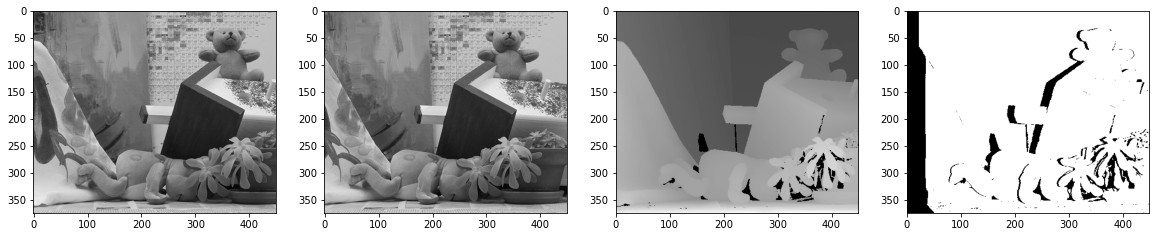

In [7]:
left = cv2.imread(os.path.join(IMG_LOAD_PATH, "im2.png") , cv2.IMREAD_GRAYSCALE)
right = cv2.imread(os.path.join(IMG_LOAD_PATH, "im6.png") , cv2.IMREAD_GRAYSCALE)
disp = cv2.imread(os.path.join(IMG_LOAD_PATH, "disp2.png") , cv2.IMREAD_GRAYSCALE)
occ = cv2.imread(os.path.join(IMG_LOAD_PATH, "teddy_occl.png") , cv2.IMREAD_GRAYSCALE)
coloured_left =cv2.imread(os.path.join(IMG_LOAD_PATH, "im2.png"))
%matplotlib inline
plu.plotNImages([left, right, disp, occ])

<IPython.core.display.Javascript object>


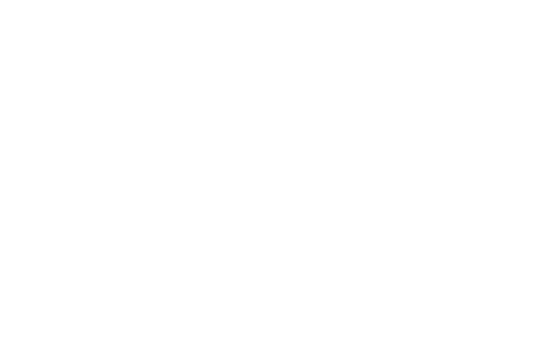

<IPython.core.display.Javascript object>


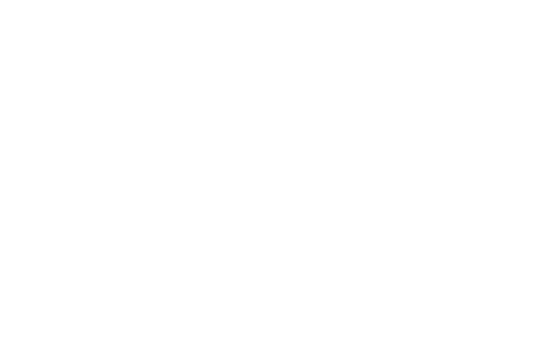

In [8]:
%matplotlib notebook
plu.plod3d_with_img_surface(disp, surface = coloured_left, finess=3, rotation=False)

# Initialising experiment variables

In [9]:
filters = list()
for i in range(3, 28, 2):
    temp = np.ones((i, i), dtype=np.int32)
    filters.append(temp)
filters = np.array(filters)

In [10]:
def get_next_image_name(kernel):
    IMG_NAME = EXPERIMENT +"_"+SELECTED_SCENE+"_"+SELECTED_IMAGE+"_"+str(kernel.shape[0])+".png"
    return IMG_NAME
def get_next_image_path(IMAGE_NAME):
    TEMP_PATH = os.path.join(IMG_SAVE_PATH, IMAGE_NAME)
    return TEMP_PATH


In [11]:
spec_dict = dict({})
spec_dict["is_parallel"] = "True"
spec_dict["alg_type"] =  "pm_numba_variable_kernel_size"
spec_dict["is_img_preprocessed"] = "False"
spec_dict["convolution_filters"] = "-"
spec_dict["filter_strategy"] = "-"
spec_dict["matching_mode"] = non_occ =  "occlusions_added_to_the_groundtruth"
spec_dict["matrix_init_mode"] = 2
spec_dict["match_base"] = 60
spec_dict["gap_base"] = -20
spec_dict["egap_base"] = 1

from components.utils import middlebury_utils as mu

disp_modified = mu.add_masks_to_raw_disparity(disp,occ)

progress_counter = 1
number_of_iterations = filters.shape[0]

In [12]:


for kernel in filters:
    match = spec_dict["match"] = spec_dict["match_base"] * kernel.shape[0]
    gap = spec_dict["gap"] =  spec_dict["gap_base"] * kernel.shape[0]
    egap = spec_dict["egap"] = spec_dict["egap_base"] * kernel.shape[0]
    spec_dict["img_name"] = get_next_image_name(kernel)
    spec_dict["img_save_path"] = get_next_image_path(spec_dict["img_name"])
    spec_dict["filter_strategy"] = "multiplyer: "+str(kernel.shape[0])

    tic = time.time()

    experiment_matcher = m(match, gap, egap)
    experiment_matcher.set_images(right, left)
    experiment_matcher.configure_instance()
    experiment_matcher.set_filter(kernel)

    x, exp_disp = experiment_matcher.run_pipeline()
    
    ABS_ERR = me.avgerr(exp_disp, disp_modified)
    mse = me.mse(exp_disp, disp_modified)
    eucledian = me.eucledian_distance(exp_disp, disp_modified)

    toc = time.time()
    spec_dict["runtime"] = toc-tic

    spec_dict["mse"] = mse
    spec_dict["euclid_distance"] =eucledian
    spec_dict["ABS_ERR"] = ABS_ERR
    log.append_new_sm_results(spec_dict)
    cv2.imwrite(spec_dict["img_save_path"], exp_disp)
    progress_bar.progress_bar(progress_counter, number_of_iterations, header= "Experiment on filter sizes in progress: ", progress_bar_steps=50)
    progress_counter+=1

Experiment on filter sizes in progress:  [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100.00 % completed: 13 / 13 steps